# Num PCA components
Use explained variance and reconstruction error to determine the number of PCA components to use.

In [70]:
from elasticSearch.selected_docs import select_rep_path
import os
from elasticSearch.recursive_search import scanRecurse

## Data
- local: 195 (first) files
- server: 1000 random files across subdirectories

In [71]:
def get_directories():
    baseDir = '/mnt/stud/home/kgutekunst/visualizations/images/'
    resDir = '/mnt/stud/home/kgutekunst/visualizations/'
    if os.path.exists('/Users/klara/Documents/uni/bachelorarbeit/data/0/'):
        baseDir = '/Users/klara/Documents/uni/bachelorarbeit/images/'
        resDir = '/Users/klara/Developer/Uni/topic-analysis-text-data/results/'
    return baseDir,resDir

In [72]:
baseDir, resDir = get_directories()

In [73]:
paths = select_rep_path(baseDir, 10) if baseDir.startswith('/mnt/') else list(scanRecurse(baseDir))

In [74]:
import numpy as np


def rgb2gray(img):  # not normalized to [0,1]
    return 0.299*img[:,:,0] + 0.587*img[:,:,1] + 0.114*img[:,:,2]

def get_maximum_height_width(documents):
    max_w = 0
    max_h = 0
    for doc in documents:
        max_w = np.maximum(max_w, doc.shape[0])
        max_h = np.maximum(max_h, doc.shape[1])
    return max_w, max_h

def proprocess_docs(raw_documents, max_w, max_h):
    '''
    return same sized, greyscale documents as an array
    '''
    documents = []
    for doc in raw_documents:
        # same size for all documents
        C = np.ones((max_w,max_h))
        # convert to grayscale
        C[:doc.shape[0],:doc.shape[1]] = rgb2gray(doc)
        # 2d to 1d array
        documents.append(C.ravel())
    # list to array
    return np.asarray(documents)

In [75]:
from matplotlib import pyplot as plt


def plot_expl_var(pca, X_train, X_test, save=False, resDir:str='results/'):
    fig, ax = plt.subplots(figsize=(10,6))
    y = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(y, label="cumulative explained variance")
    plt.title("Cumulative explained varianceon a ", X_train.shape[0], '/', X_test.shape[0]. 'values train/test set')
    plt.xlabel("Number of components")
    plt.ylabel("Explained variance")
    plt.axhline(y = 0.9, color = 'r', linestyle = '-', label="90% explained variance")
    interp = np.interp(0.9, y, list(range(len(y))))
    plt.axvline(x=interp,color='grey', label="{} components".format(int(interp)))
    plt.legend()
    if save:
        plt.savefig(resDir + "cumulative_explained_variance.pdf", format="pdf")
    plt.show()

In [104]:
from sklearn.decomposition import PCA


def plot_rec_err(X_train, X_test, n_max=10, save=False, resDir:str='results/'):
    reconstr_err = []
    for i in range(1, n_max):
        pca = PCA(n_components=i, whiten=True, svd_solver="randomized")   
        pca.fit(X_train)
        X_test_pca = pca.transform(X_test)
        X_test_pca_inverse = pca.inverse_transform(X_test_pca)
        sqr_dif = (X_test - X_test_pca_inverse)**2
        # RSME / (portion of non white pixel * # pictures)
        # portion of non white pixel = pixel with low values (255 -> 1) == average colour-/signal-portion
        # divisor is average portion of non white pixel per image
        reconstr_err.append(np.sqrt(np.mean(sqr_dif))/(np.sum(np.abs(1-X_test))/X_test.shape[0])) 

    # plot reconstruction error
    plt.figure(figsize=(10,6))
    plt.plot(reconstr_err, label="RSME / avg # non white pixel per image")
    plt.title("Reconstruction error on a ", X_train.shape[0], '/', X_test.shape[0]. 'values train/test set')
    plt.xlabel("Number of components")
    plt.ylabel("Weighted RSME")
    plt.legend()
    if save:
        plt.savefig(resDir + "pca_reconstruction_error.pdf", format="pdf")
    plt.show()
    

In [101]:
print(max(X_test[0]))

1.0


In [77]:
documents_raw = [plt.imread(fp) for fp in paths if fp.endswith(".png")]

In [78]:
max_w, max_h = get_maximum_height_width(documents_raw)
print(max_w, max_h)

880 1026


In [79]:
eigendocs = proprocess_docs(documents_raw, max_w=max_w, max_h=max_h)

In [80]:
from sklearn.model_selection import train_test_split


X_train, X_test = train_test_split(eigendocs, random_state=0)

In [81]:
pca = PCA(n_components=min(len(X_train), len(X_train[0])), whiten=True, svd_solver="randomized")   
pca.fit(X_train)

PCA(n_components=145, svd_solver='randomized', whiten=True)

In [82]:
plot_expl_var(pca, X_train=X_train, X_test=X_test, save=True, resDir=resDir)

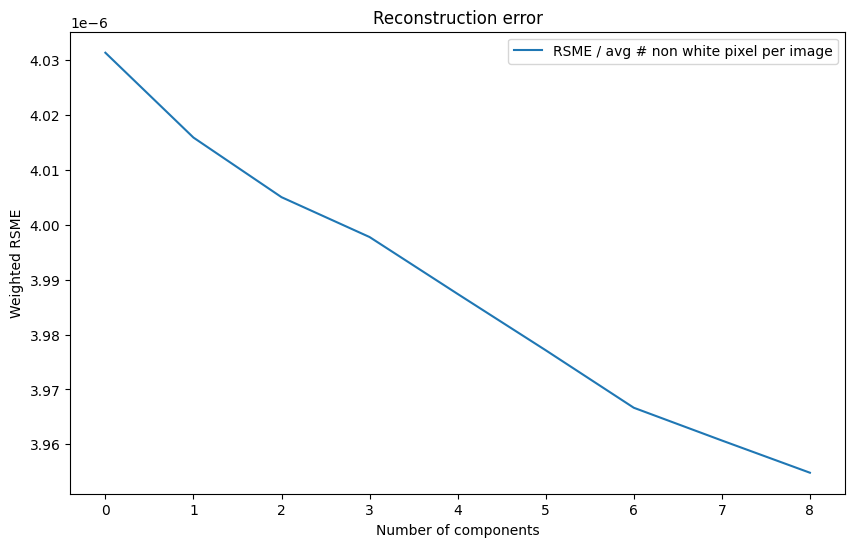

In [105]:
plot_rec_err(X_train=X_train, X_test=X_test, n_max= min(len(X_train),len(X_train[0])), save=True, resDir=resDir)